<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Mohammad Parham Bateni
### Student Number : 99105294
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [154]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
import seaborn as sns


In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [52]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.PILToTensor(),
                                     transforms.ConvertImageDtype(torch.float),
                                     transforms.Normalize(mean=0.1307,std=0.3081)])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [53]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [54]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data,batch_size=16,shuffle=True)
val_loader = DataLoader(valid_data,batch_size=16,shuffle=True)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

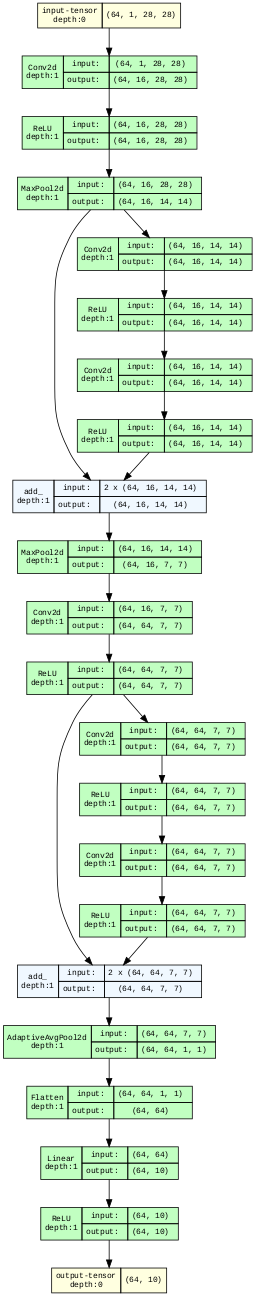

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [109]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
  def __init__(self):
    super(ResidualClassifier,self).__init__()
    self.block0=nn.Sequential(nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding='same'),
                               nn.ReLU(),
                               nn.BatchNorm2d(16),
                               nn.MaxPool2d(kernel_size=2,stride=2))
    self.block1=nn.Sequential(nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding='same'),
                               nn.ReLU(),
                               nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding='same'),
                               nn.ReLU(),
                               nn.BatchNorm2d(16))
    self.block2=nn.Sequential(nn.MaxPool2d(kernel_size=2,stride=2),
                             nn.Conv2d(in_channels=16,out_channels=64,kernel_size=3,padding='same'),
                             nn.ReLU(),
                             nn.BatchNorm2d(64))
    self.block3=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding='same'),
                               nn.ReLU(),
                               nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding='same'),
                               nn.ReLU(),
                               nn.BatchNorm2d(64))
    self.block4=nn.Sequential(nn.AdaptiveAvgPool2d(1),
                             nn.Flatten(),
                             nn.Linear(in_features=64,out_features=10),
                             nn.ReLU(),
                             nn.Softmax(dim=1))
    # self.layers=nn.Sequential(layer0,layer1,layer2,layer3,layer4)
  def forward(self, x):
    y1=self.block0(x)
    x=self.block1(y1)
    y2=self.block2(y1+x)
    x=self.block3(y2)
    y3=self.block4(y2+x)
    return y3
  def predict(self,x):
    return np.argmax(self.forward(x))

# Train Model (30 Points)

In [112]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
learning_rate=0.01
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
print(model)

ResidualClassifier(
  (block0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): 

In [114]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
train_losses=[]
train_accuracies=[]
valid_losses=[]
valid_accuracies=[]

best_model=None
best_valid_accuracy=0
for epoch in range(num_epochs):
  print(f'******************************\nEpoch {epoch+1}: ',end='')
  epoch_loss=0
  count_true_preds=0
  for (images, labels) in train_loader:  
      pred=model(images.to(device))
      loss=criterion(pred,labels.to(device))
      count_true_preds+=(pred.argmax(1)==labels.to(device)).type(torch.float).sum().item()
      epoch_loss+=loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_loss=epoch_loss/total_step
  train_accuracy=count_true_preds/len(train_loader.dataset)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  print(f'Train loss: {train_loss}\t Train accuracy: {train_accuracy}')

  epoch_loss=0
  count_true_preds=0
  with torch.no_grad():
      for images, labels in val_loader:
          pred=model(images.to(device))
          loss=criterion(pred,labels.to(device))
          epoch_loss+=loss.item()
          count_true_preds+=(pred.argmax(1)==labels.to(device)).type(torch.float).sum().item()
  valid_loss=epoch_loss/total_step
  valid_accuracy=count_true_preds/len(val_loader.dataset)
  valid_losses.append(valid_loss)
  valid_accuracies.append(valid_accuracy)
  print(f'Validation loss: {valid_loss}\t Validation accuracy: {valid_accuracy}')
  if valid_accuracy >best_valid_accuracy:
    best_valid_accuracy=valid_accuracy
    best_model=model

******************************
Epoch 1: Train loss: 1.505216202468872	 Train accuracy: 0.9714
Validation loss: 0.29988013080596926	 Validation accuracy: 0.9746
******************************
Epoch 2: Train loss: 1.4950668003463745	 Train accuracy: 0.97698
Validation loss: 0.29891085437774656	 Validation accuracy: 0.9755
******************************
Epoch 3: Train loss: 1.4890453275680542	 Train accuracy: 0.98086
Validation loss: 0.2980100252151489	 Validation accuracy: 0.979
******************************
Epoch 4: Train loss: 1.484818141822815	 Train accuracy: 0.9839
Validation loss: 0.2974536276245117	 Validation accuracy: 0.9804
******************************
Epoch 5: Train loss: 1.4830662422180176	 Train accuracy: 0.98428
Validation loss: 0.29719780712127686	 Validation accuracy: 0.9819
******************************
Epoch 6: Train loss: 1.4798377731704713	 Train accuracy: 0.98692
Validation loss: 0.29659517723083495	 Validation accuracy: 0.9842
******************************
Epoc

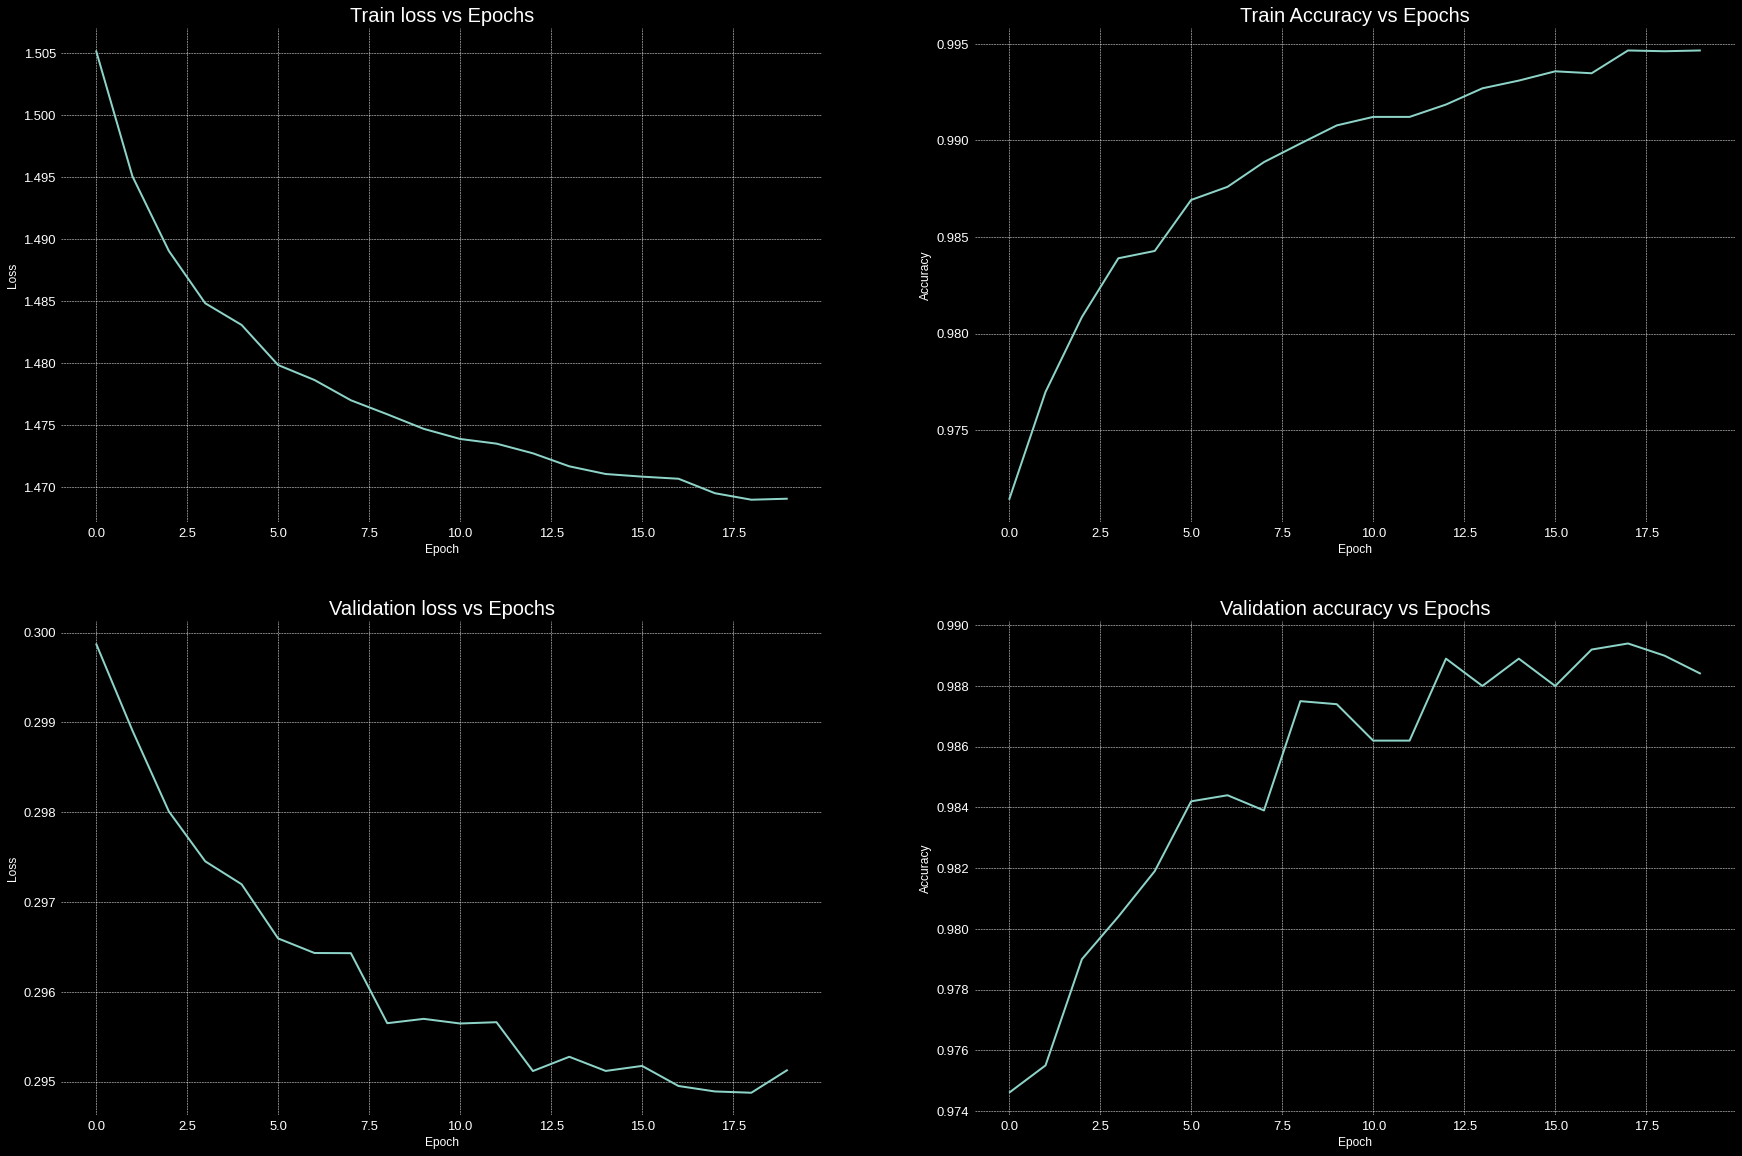

In [145]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.style.use('dark_background')
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 20
fig,axes=plt.subplots(2,2,figsize=(30,20))

axes[0][0].set_title('Train loss vs Epochs')
axes[0][0].set_xlabel('Epoch')
axes[0][0].set_ylabel('Loss')
axes[0][0].plot(np.arange(0,len(train_losses)),train_losses)

axes[0][1].set_title('Train Accuracy vs Epochs')
axes[0][1].set_xlabel('Epoch')
axes[0][1].set_ylabel('Accuracy')
axes[0][1].plot(np.arange(0,len(train_accuracies)),train_accuracies)

axes[1][0].set_title('Validation loss vs Epochs')
axes[1][0].set_xlabel('Epoch')
axes[1][0].set_ylabel('Loss')
axes[1][0].plot(np.arange(0,len(valid_losses)),valid_losses)

axes[1][1].set_title('Validation accuracy vs Epochs')
axes[1][1].set_xlabel('Epoch')
axes[1][1].set_ylabel('Accuracy')
axes[1][1].plot(np.arange(0,len(valid_accuracies)),valid_accuracies)


# Test Model (20 Points)

In [159]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
confusion_matrix=np.zeros((10,10),dtype=np.int32)
with torch.no_grad():
    for images,labels in test_loader:
      pred=best_model(images.to(device))
      predicted_numbers=pred.argmax(1)
      for i,predicted_number in enumerate(predicted_numbers):
        confusion_matrix[predicted_number,labels[i]]+=1
    print(f'Test accuracy is: {confusion_matrix.trace()/np.sum(confusion_matrix)}')
    print('Confusion matrix:')
    print(confusion_matrix)

10000
Test accuracy is: 0.993
Confusion matrix:
[[ 978    0    3    0    0    1    3    0    2    1]
 [   0 1132    0    0    0    0    3    3    0    1]
 [   0    1 1027    0    0    0    1    3    1    0]
 [   0    0    0 1003    0    5    0    1    0    0]
 [   0    1    1    0  975    0    0    0    0    8]
 [   1    0    0    5    0  884    1    0    1    2]
 [   0    0    0    0    0    1  948    0    0    0]
 [   1    1    1    0    0    1    0 1019    0    1]
 [   0    0    0    2    2    0    2    0  968    0]
 [   0    0    0    0    5    0    0    2    2  996]]


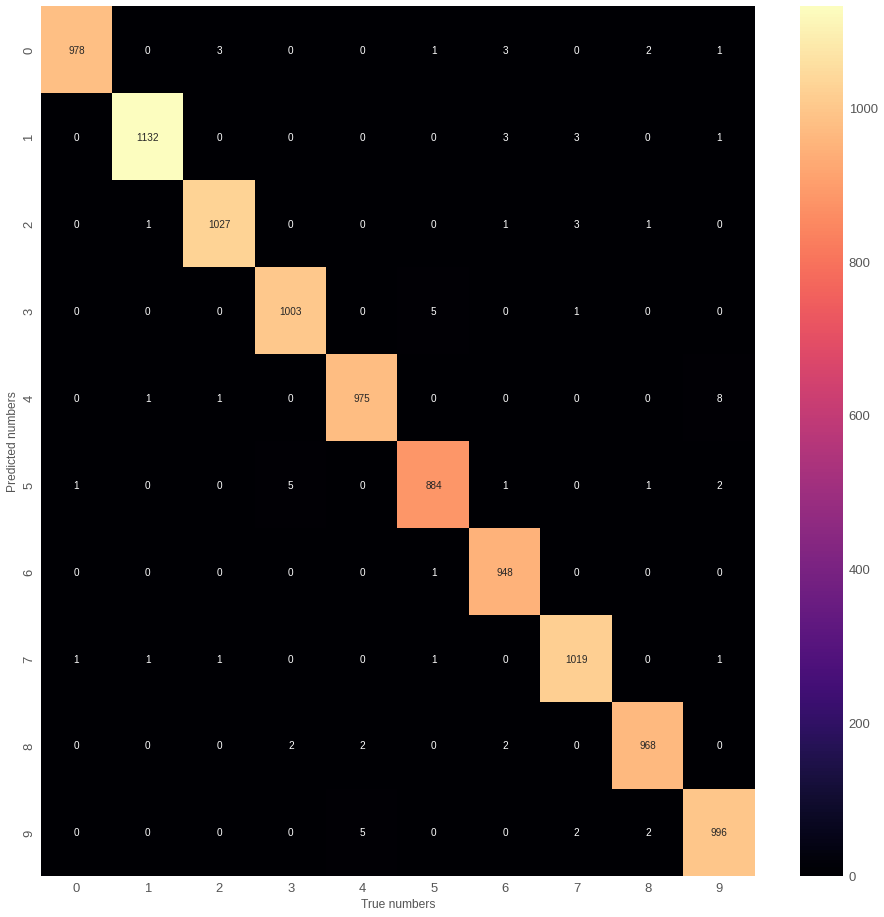

In [183]:
fig, ax = plt.subplots(figsize=(16,16))
heatmap=sns.heatmap(confusion_matrix,cmap='magma',annot=True,ax=ax,fmt='')
ax.set_xlabel('True numbers')
ax.set_ylabel('Predicted numbers')
plt.show()